# Lab work # 3: Lazy learner k-Nearest Neighbour

> Student name    - Daria

> Student surname - Uzenkova

> Group           - CS-31

# Description of the work

## Theory
* [Lazy Learning Wiki](https://en.wikipedia.org/wiki/Lazy_learning)
* [k-Nearest Neighbour Wiki](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)

### k-NN metrics:
* `n_neighbours` -- number neighbours to vote
* `p` -- the distance metric (Euclid Distance, Mahalanobis Distance, Manhattan Distance (L1), L2, cosine, and [other available metric could be found here](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html))

## Dataset

3. [Fitness Classification Dataset](https://www.kaggle.com/datasets/muhammedderric/fitness-classification-dataset-synthetic)


## Task description

1. Build lazy learner as was shown in the experiment part.
2. Do experiments with various metrics (not only included in the list)
3. Do experiments with various data separations.
4. WARNING: for testing while doing experiments on non-toy data do train-val-test data split. It'll show more realistic performance of your model.
5. WARNING: for unbalanced data prefer using other metrics (not "accuracy", but "f1-macro" / "precision" / "recall"), be inventive in this question.


# Import dependencies

In [1]:
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from tqdm import tqdm
import warnings  


# Some useful code

In [2]:
def plot_classifier_boundary(X, y, model=None, title=None, resolution=200):
    """
    Visualizes classifier decision boundaries using a high-resolution, evenly-spaced grid.

    If a model is provided, it plots the decision regions.
    If model is None, it only plots the data points.

    :param X: The feature matrix, shape (n_samples, 2).
    :param y: The true label vector, shape (n_samples,).
    :param model: A trained scikit-learn classifier object. Optional.
    :param title: The title for the plot. A default is used if None.
    :param resolution: The number of points to use per axis for the background grid.
    """
    plt.style.use('seaborn-v0_8-pastel')
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the background decision regions only if a model is provided
    if model is not None:
        # 1. Define the plot boundaries with a 10% padding
        x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
        x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
        x1_pad = (x1_max - x1_min) * 0.2
        x2_pad = (x2_max - x2_min) * 0.2
        plot_x1_min, plot_x1_max = x1_min - x1_pad, x1_max + x1_pad
        plot_x2_min, plot_x2_max = x2_min - x2_pad, x2_max + x2_pad

        # 2. Create a high-resolution, evenly-spaced grid of points
        xx1, xx2 = np.meshgrid(
            np.linspace(plot_x1_min, plot_x1_max, resolution),
            np.linspace(plot_x2_min, plot_x2_max, resolution)
        )
        
        # 3. Get the model's prediction for every point on the grid
        # We flatten the grid to pass it to the model, then reshape the predictions back
        grid_points = np.c_[xx1.ravel(), xx2.ravel()]
        Z = model.predict(grid_points)
        Z = Z.reshape(xx1.shape)
        
        # 4. Plot the regions using filled contours
        ax.contourf(xx1, xx2, Z, cmap=plt.cm.coolwarm, alpha=0.6)

    # 5. Plot the original data points on top
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', alpha=1.0, zorder=2)

    # Set a dynamic title if none is provided
    if title is None:
        title = "Classifier Decision Boundary" if model is not None else "Data Scatter Plot"
    
    ax.set_xlabel("Feature 1", fontsize=12)
    ax.set_ylabel("Feature 2", fontsize=12)
    ax.set_title(title, fontsize=14, weight='bold')

    # --- Legend Creation ---
    handles, _ = scatter.legend_elements()
    num_classes = len(np.unique(y))
    class_labels = [f'Class {i}' for i in range(num_classes)]
    ax.legend(handles=handles, labels=class_labels, loc='upper right', fontsize=11)
    
    if model is not None:
        ax.set_xlim(plot_x1_min, plot_x1_max)
        ax.set_ylim(plot_x2_min, plot_x2_max)
    
    plt.show()

## 2. Real data example

## 2.1. Load & prepare data

In [3]:
# Завантаження та аналіз даних

# 1. Завантаження
print("Завантаження та аналіз даних")
try:
    df = pd.read_csv("./fitness_dataset.csv") 
except FileNotFoundError:
    print("Помилка: Файл 'fitness_dataset.csv' не знайдено.")
    df = pd.DataFrame() # Створюємо порожній DataFrame, щоб код не впав

if not df.empty:
    print(f"Початковий розмір даних: {df.shape}")
    print("\nІнформація про дані (до очищення):")
    df.info()
else:
    print("DataFrame порожній. Подальше виконання зупинено.")

Завантаження та аналіз даних
Початковий розмір даних: (2000, 11)

Інформація про дані (до очищення):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                2000 non-null   int64  
 1   height_cm          2000 non-null   int64  
 2   weight_kg          2000 non-null   int64  
 3   heart_rate         2000 non-null   float64
 4   blood_pressure     2000 non-null   float64
 5   sleep_hours        1840 non-null   float64
 6   nutrition_quality  2000 non-null   float64
 7   activity_index     2000 non-null   float64
 8   smokes             2000 non-null   object 
 9   gender             2000 non-null   object 
 10  is_fit             2000 non-null   int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 172.0+ KB


In [4]:
df.head()

,age,height_cm,weight_kg,heart_rate,blood_pressure,sleep_hours,nutrition_quality,activity_index,smokes,gender,is_fit
0,56,152,65,69.6,117.0,NaN,2.37,3.97,no,F,1
1,69,186,95,60.8,114.8,7.5,8.77,3.19,0,F,1
2,46,192,103,61.4,116.4,NaN,8.20,2.03,0,F,0
3,32,189,83,60.2,130.1,7.0,6.18,3.68,0,M,1
4,60,175,99,58.1,115.8,8.0,9.95,4.83,yes,F,1


In [5]:
# Очищення та кодування даних

if not df.empty:
    # 2. Очищення та кодування
    print("\nОчищення та кодування даних")
    
    # Кодування 'gender'
    gender_encoder = LabelEncoder()
    df['gender'] = gender_encoder.fit_transform(df['gender'])

    # Кодування 'smokes'
    smokes_mapping = {'no': 0, '0': 0, 0: 0, 'yes': 1, '1': 1, 1: 1}
    df['smokes'] = df['smokes'].map(smokes_mapping)

    # Заповнення пропусків (NaN)
    df['smokes'] = df['smokes'].fillna(df['smokes'].median()) 
    numeric_cols = df.select_dtypes(include=np.number).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

    print("\nІнформація про дані (після очищення):")
    df.info()
else:
    print("DataFrame порожній.")


Очищення та кодування даних

Інформація про дані (після очищення):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                2000 non-null   int64  
 1   height_cm          2000 non-null   int64  
 2   weight_kg          2000 non-null   int64  
 3   heart_rate         2000 non-null   float64
 4   blood_pressure     2000 non-null   float64
 5   sleep_hours        2000 non-null   float64
 6   nutrition_quality  2000 non-null   float64
 7   activity_index     2000 non-null   float64
 8   smokes             2000 non-null   int64  
 9   gender             2000 non-null   int64  
 10  is_fit             2000 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 172.0 KB


In [6]:
# Визначення X/y та перевірка балансу

if not df.empty:
    print("\n=Визначення X/y та перевірка балансу")
    X_df = df.drop(columns=['is_fit'])
    y_df = df['is_fit']

    print("\nБаланс класів (is_fit):")
    print(y_df.value_counts(normalize=True) * 100)
    target_names = ['Not Fit (0)', 'Fit (1)']
else:
    print("DataFrame порожній.")


=Визначення X/y та перевірка балансу

Баланс класів (is_fit):
is_fit
0    60.05
1    39.95
Name: proportion, dtype: float64


In [7]:
# Масштабування та розділення

if not df.empty:
    print("\n Масштабування та розділення ")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_df)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_df, test_size=0.3, random_state=42, stratify=y_df
    )

    print(f"\nРозмір тренувальної вибірки (X_train): {X_train.shape}")
    print(f"Розмір тестової вибірки (X_test): {X_test.shape}")
else:
    print("DataFrame порожній.")


 Масштабування та розділення 

Розмір тренувальної вибірки (X_train): (1400, 10)
Розмір тестової вибірки (X_test): (600, 10)


## 2.2. Do training of your k-NN model

In [8]:
print("\n Запуск циклу експериментів ")

experiment_results = []
metrics_to_test = ["manhattan", "minkowski", "cosine", "euclidean"] 
k_values = range(1, 32, 2)

train_percentages = np.arange(0.05, 1.0, 0.05) 

for train_percent in tqdm(train_percentages, desc="Прогрес експериментів"):
    
    try:
        X_train_mem, _, y_train_mem, _ = train_test_split(
            X_train, y_train, 
            train_size=train_percent, 
            random_state=42, 
            stratify=y_train
        )
    except ValueError:
        continue
        
    if len(np.unique(y_train_mem)) < 2:
        continue

    for metric in metrics_to_test:
        for k in k_values:
            if k >= len(y_train_mem):
                continue

            knn_model = KNeighborsClassifier(n_neighbors=k, metric=metric)
            knn_model.fit(X_train_mem, y_train_mem)
            
            y_val_pred = knn_model.predict(X_train)
            
            score = f1_score(y_train, y_val_pred, average='macro')

            experiment_results.append((metric, train_percent, k, score))



 Запуск циклу експериментів 


Прогрес експериментів: 100%|██████████| 19/19 [00:27<00:00,  1.44s/it]


In [9]:
print(f"\nПроведено {len(experiment_results)} експериментів.")
print("Приклад результатів:")
print(experiment_results[:5])


Проведено 1216 експериментів.
Приклад результатів:
[('manhattan', np.float64(0.05), 1, 0.6649165302782324), ('manhattan', np.float64(0.05), 3, 0.692037117244819), ('manhattan', np.float64(0.05), 5, 0.6966085166323546), ('manhattan', np.float64(0.05), 7, 0.6950811261670407), ('manhattan', np.float64(0.05), 9, 0.7009117787595177)]


In [10]:
print("\nВізуалізація 3D-графіків")

vis_df = pd.DataFrame(experiment_results, columns=['metric', 'train_data_portion', 'k', 'f1_macro'])

for metric in metrics_to_test:
    metric_data = vis_df[vis_df['metric'] == metric]
    
    fig = px.scatter_3d(
        metric_data, 
        x='train_data_portion',
        y='k', 
        z='f1_macro',
        title=f"k-NN F1-Macro (Fitness) | Метрика: *{metric}*",
        color="f1_macro",
        color_continuous_scale='Viridis',
        width=800, height=600
    )
    
    fig.update_layout(
        scene = dict(
            xaxis_title='Частка тренувальних даних (Train Size)', 
            yaxis_title='k (кількість сусідів)',
            zaxis_title='F1-Macro Score'
        )
    )
    fig.update_traces(marker=dict(size=3))
    fig.show()


Візуалізація 3D-графіків


In [11]:
# Фінальна модель та оцінка (звіти)

print("\n Навчання та оцінка фінальної моделі")

best_params = sorted(experiment_results, key=lambda x: x[3], reverse=True)[0]
best_metric, best_train_portion, best_k, best_score = best_params

print(f"Найкращі параметри (з валідації на X_train)")
print(f"Метрика (Metric):     {best_metric}")
print(f"k (сусіди):         {best_k}")
print(f"Частка даних:       {best_train_portion:.2f} (де це було досягнуто)")
print(f"Найкращий F1-Macro: {best_score:.4f}")


 Навчання та оцінка фінальної моделі
Найкращі параметри (з валідації на X_train)
Метрика (Metric):     minkowski
k (сусіди):         1
Частка даних:       0.95 (де це було досягнуто)
Найкращий F1-Macro: 0.9881


In [12]:
# Навчаємо фінальну модель на всіх X_train з найкращими знайденими k і метрикою
final_knn_model = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
final_knn_model.fit(X_train, y_train)

,n_neighbors,1
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [13]:
# Оцінка на TRAIN
y_train_pred = final_knn_model.predict(X_train)
print("\nЗВІТ ПО TRAIN")
print(classification_report(y_train, y_train_pred, target_names=target_names))


ЗВІТ ПО TRAIN
              precision    recall  f1-score   support

 Not Fit (0)       1.00      1.00      1.00       841
     Fit (1)       1.00      1.00      1.00       559

    accuracy                           1.00      1400
   macro avg       1.00      1.00      1.00      1400
weighted avg       1.00      1.00      1.00      1400



In [14]:
# Оцінка на TEST (найважливіший результат)
y_test_pred = final_knn_model.predict(X_test)
print("\nЗВІТ ПО TEST")
print(classification_report(y_test, y_test_pred, target_names=target_names))


ЗВІТ ПО TEST
              precision    recall  f1-score   support

 Not Fit (0)       0.75      0.74      0.75       360
     Fit (1)       0.62      0.64      0.63       240

    accuracy                           0.70       600
   macro avg       0.69      0.69      0.69       600
weighted avg       0.70      0.70      0.70       600




Візуалізація матриць помилок


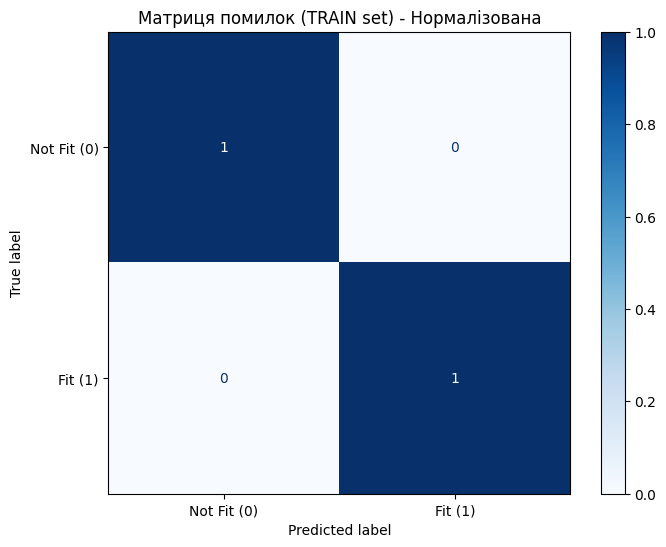

In [15]:
print("\nВізуалізація матриць помилок")

# Матриця помилок для TRAIN
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(False)
ConfusionMatrixDisplay.from_estimator(
    final_knn_model,
    X_train,
    y_train,
    display_labels=target_names,
    cmap=plt.cm.Blues,
    ax=ax,
    normalize='true'
)
plt.title("Матриця помилок (TRAIN set) - Нормалізована")
plt.show()

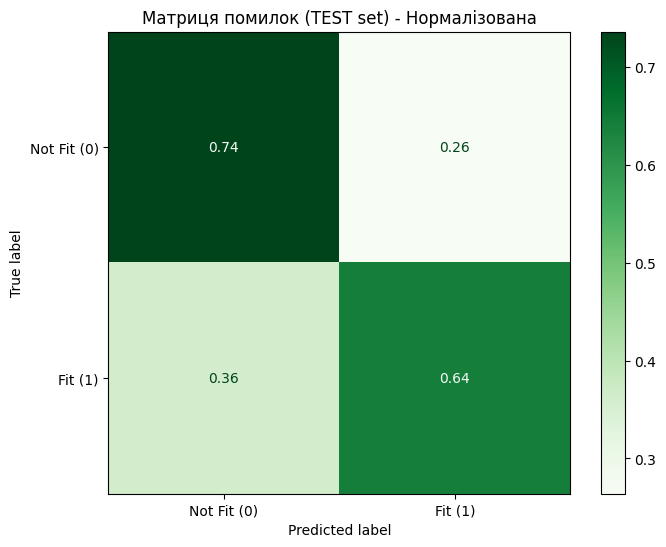

In [16]:
# Матриця помилок для TEST
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(False)
ConfusionMatrixDisplay.from_estimator(
    final_knn_model,
    X_test,
    y_test,
    display_labels=target_names,
    cmap=plt.cm.Greens,
    ax=ax,
    normalize='true' 
)
plt.title("Матриця помилок (TEST set) - Нормалізована")
plt.show()

# Conclusions

В ході лабораторної роботи був досліджений алгоритм k-NN на "Fitness Classification Dataset".

Підготовка даних: Була проведена повна підготовка даних, що включала заповнення пропусків (NaN) медіаною, кодування категоріальних ознак (gender, smokes) та критично важливе масштабування всіх ознак за допомогою StandardScaler.

Метрика: Через дисбаланс класів (60/40) замість accuracy було обрано f1-score (macro) як основну метрику.

Експерименти: Було проведено серію експериментів, тестуючи 4 метрики відстані (manhattan, euclidean та ін.), 16 значень k та 19 варіантів обсягу тренувальних даних.

Результати та аналіз:

Під час валідації (на X_train) найкраща модель показала F1-Macro 0.9881 з метрикою minkowski та k=1.

Однак, на "невидимих" тестових даних (X_test), ця ж модель показала значно нижчий, "чесний" результат: f1-score (macro) = 0.69.

Ця різниця (0.9881 vs 0.69) є яскравим прикладом перенавчання (overfitting): модель ідеально "запам'ятала" тренувальні дані, але мала труднощі з узагальненням.

Загальний висновок: Алгоритм k-NN виявився працездатним, але схильним до перенавчання на цьому наборі даних. Його ефективність критично залежала від масштабування. Фінальна узагальнююча здатність моделі склала f1-macro = 0.69.